# Team BackProp - Data Science Notebook

During exploration of the neural architecture, we used copies of this notebook to be able to easily process data whilst keeping our models intact. 

The general overview of the data modelling pipeline is as follows:

1. Import KMNIST Data
2. Data preprocess and augmentate
3. Develop neural network model
4. Cross validate model
    - At this stage we decide whether to keep the model for full training or remodify the network again to improve it.
5. Hyperparameter Tuning
6. Train on the full dataset
7. Save model and Submission


In [0]:
!pip install pycm livelossplot
%pylab inline

## Pipeline Preparation

### Import Modules

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset 
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage, RandomResizedCrop, RandomAffine
import random
import itertools
from sklearn.model_selection import StratifiedKFold
import pickle

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Import KMNIST Dataset

In [0]:
# Load in the datasets
X_train_orig = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-imgs.npy") /255
y_train_orig = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-labels.npy")
X_test_orig = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-test-imgs.npy") /255

In [0]:
# Load in the classmap as a dictionary
classmap = {}
with open('/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist_classmap.csv', 'r') as csvfile:
   spamreader = csv.reader(csvfile, delimiter=',')
   next(spamreader)
   for row in spamreader:
       classmap[row[0]] = row[2]

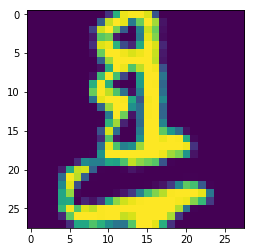

In [0]:
# Check if we imported correctly
plt.imshow(X_train_orig[104])

## Processing Functions

### Train, Validate and Evaluate Functions

In [0]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        # the dimension here was changed to match our KMNIST's dimension
        a2 = model(X.view(-1, 1, 28, 28).float()) 
        
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            
            # the dimension here was changed to match our KMNIST's dimension
            a2 = model(X.view(-1, 1, 28, 28).float())
            
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            
            # the dimension here was changed to match our KMNIST's dimension
            a2 = model(X.view(-1, 1, 28, 28).float())
            
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

### Training Model Function

In [0]:
def train_model(wd, lrt, model, train_loader, validate_loader):
  set_seed(seed)
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lrt, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd, amsgrad=False)
  criterion = nn.CrossEntropyLoss()
  
  liveloss = PlotLosses()
  for epoch in range(n_epochs):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validate_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

  return liveloss, validation_loss, validation_accuracy

### K-Fold Validation Function

In [0]:
def kfold_datasets(n_splits, X_train_orig, y_train_orig, trans=True, verbatim=False):
  '''Wrapper function that returns a list of train/val datasets which have been 
     subjected to the KFold method. 
  '''
  
  kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  fold_train_loader = [] # list of shuffled training dataloaders
  fold_validation_loader = [] # list of shuffled validation dataloaders

  for train_index, test_index in kf.split(X_train_orig, y_train_orig):
    if verbatim: print("TRAIN:", train_index, "Validation:", test_index)
    X_train, X_val = X_train_orig[train_index], X_train_orig[test_index]
    y_train, y_val = y_train_orig[train_index], y_train_orig[test_index]

    if verbatim: print("train size:", X_train.shape, "test size:", X_val.shape)

    # Convert to tensor
    X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train)
    X_val, y_val = torch.from_numpy(X_val).float(), torch.from_numpy(y_val)
    
    # Find mean std
    mean1, std1 = torch.mean(X_train), torch.std(X_train)

    # make Custom set
    train_dataset = CustomImageTensorDataset(X_train, y_train.long(), transform=trans, mean=mean1, std=std1)
    validation_dataset = CustomImageTensorDataset(X_val, y_val.long(), transform=False, mean=mean1, std=std1)

    # initialize the data-loaders
    fold_train_loader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4))
    fold_validation_loader.append(DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0))
    


In [0]:
def train_model_kfold(wd, lrt, fold_train_loader, fold_validation_loader):
  """ function to easily train the model with weight_decay as input parameter.
  
      HOW TO RUN THE FUNCTION:
      fold_train_loader, fold_validation_loader = kfold_datasets(5, X_train_orig, y_train_orig, False)
      lloss, loss, acc = train_model_kfold(weight_decay[3], fold_train_loader, fold_validation_loader)
  """
  
  fold_liveloss = []
  fold_loss = 0.
  fold_acc = 0.
  for fold in range(len(fold_train_loader)):
    # CHANGE THE MODEL HERE:
    model = LeNet5()

    liveloss, val_loss, val_acc = train_model(wd, lrt, model, fold_train_loader[fold], fold_validation_loader[fold])
    fold_liveloss.append(liveloss)
    fold_loss += val_loss
    fold_acc += val_acc
    print("fold:", fold)
    
  print("Averaged Accuracy: ", (fold_acc/len(fold_train_loader))*100)
  return fold_liveloss, fold_loss, fold_acc

## Image Preprocessing and Augmentation

In [0]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None, mean=False, std=False):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data.reshape(-1,1,28,28)
        self.targets = targets
        self.transform = transform

        # Find mean and standard dev
        self.mean = mean
        self.std = std
        
        
        self.Rotation = Compose([
                                  ToPILImage(),
                                   RandomRotation(10),
                                   ToTensor(), Normalize(mean=[self.mean], std=[self.std])
                                ])

        self.RotandCrop = Compose([
                                  ToPILImage(),
                                   RandomResizedCrop(size=(28,28), scale=(0.8,1)),
                                  ToTensor(), Normalize(mean=[self.mean], std=[self.std])
                                 ])
        
        self.Affine = Compose([ToPILImage(),
                                   RandomAffine(10, shear=10),
                                   ToTensor(), Normalize(mean=[self.mean], std=[self.std])
                                ])
 
        
        self.Norm = Compose([Normalize(mean=[self.mean], std=[self.std])
                                 ])
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        
        assert (self.mean != False), "Asign a mean"
        assert (self.mean != False), "Asign a std"
        
        if self.transform:
            x = random.random()
            if 0<= x<0.2: # rotate
              sample = self.Rotation(sample)
            if 0.2<= x<0.4: # resize crop
              sample = self.RotandCrop(sample)
            if 0.4<= x<0.7: # shear crop
              sample= self.Affine(sample)
              
            else: # none
              sample = self.Norm(sample)
        else:
           sample = self.Norm(sample)
            
        return sample, label

torch.Size([25, 1, 28, 28])
max: tensor(6.1103)


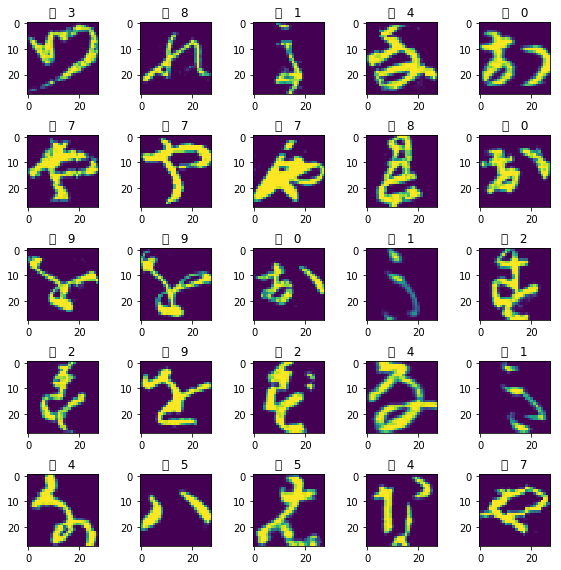

In [0]:
# Check if our data augmentation/preprocessing works

# Create a new custom image dataset:
X_train, y_train = X_train_orig.astype(float), y_train_orig
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train)
mean1, std1 = torch.mean(X_train), torch.std(X_train)
dset = CustomImageTensorDataset(X_train, y_train, transform=True, mean=mean1, std=std1 )

# Make a dataloader to access the PIL images of a batch size of 25
loader = DataLoader(dset, batch_size=25, shuffle=True)

# Create an iter object to cycle through dataloader
train_iter = iter(loader)
imgs, labels = train_iter.next()

print(imgs.shape)
print('max:',imgs.max())

# plot our batch of images with label names
fig, axarr = plt.subplots(5,5,figsize=(8,8))
fig.tight_layout()
for img, label, axs in zip(imgs, labels, axarr.flatten()):
    axs.set_title(classmap[str(label.numpy())] + "   " + str(label.numpy()))
    axs.imshow(img.numpy()[0])

## 1. Model Development



### Architecture Analysis Models


In [0]:
class AlexNet_Exp1(nn.Module):
  """Based on the AlexNet paper with the same number of layers and parameters 
      are rescaled down by 8x to fit with the original alexnet image size to 
      our kmnist size ratio (227:28)
  """
  
  def __init__(self):
    super(AlexNet_Exp1, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=2, bias=True)
    self.conv_7 = nn.Conv2d(24, 16, kernel_size=3, stride=1, padding=2, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(400, 256, bias=True)
    self.output = nn.Linear(256, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp3(nn.Module):
  """Based on the AlexNet paper with the same number of layers and parameters 
      are rescaled down by 4x to better fit to the labels compared to 8x scaling
  """
  
  def __init__(self):
    super(AlexNet_Exp3, self).__init__()
    self.conv_1 = nn.Conv2d(1, 12, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(12, 32, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=2, bias=True)
    self.conv_7 = nn.Conv2d(48, 32, kernel_size=3, stride=1, padding=2, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(800, 512, bias=True)
    self.output = nn.Linear(512, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp4(nn.Module):
  """Based on the AlexNet paper with the same number of channels and layers 
      are rescaled down by 8x to fit with the original alexnet image size to 
      our kmnist size ratio (227:28)
      
      We have now provided a "reasonable" guess of the filters and paddings 
      
  """
  
  def __init__(self):
    super(AlexNet_Exp4, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1, bias=True)
    self.conv_7 = nn.Conv2d(24, 16, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(144, 128, bias=True)
    self.output = nn.Linear(128, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp5(nn.Module):
  """Based on the AlexNet paper with the same number of layers and parameters 
      are rescaled down by 8x but with an addional convolutional layer 
  """
  
  def __init__(self):
    super(AlexNet_Exp5, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=13, stride=1, padding=6, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=7, stride=1, padding=3, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2, bias=True)
    
    # additional layer
    self.conv_6 = nn.Conv2d(24, 24, kernel_size=5, stride=1, padding=2, bias=True)
    
    self.conv_7 = nn.Conv2d(24, 24, kernel_size=4, stride=1, padding=1, bias=True)
    self.conv_8 = nn.Conv2d(24, 16, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_9 = nn.MaxPool2d(kernel_size=2)
    self.linear_10 = nn.Linear(144, 100, bias=True)
    self.output = nn.Linear(100, 10, bias=True)
    
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    
    x = self.act(self.conv_6(x))
    
    x = self.act(self.conv_7(x))
    x = self.act(self.conv_8(x))
    x = self.pool_9(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_10(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp6(nn.Module):
  """ Based on the AlexNet paper with the same number of channels and layers 
      are rescaled down by 4x to fit with the original alexnet image size to 
      our kmnist size ratio (227:28)
      
      We have now provided a "reasonable" guess of the filters and paddings 
      
  """
  
  def __init__(self):
    super(AlexNet_Exp6, self).__init__()
    self.conv_1 = nn.Conv2d(1, 12, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(12, 32, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1, bias=True)
    self.conv_7 = nn.Conv2d(48, 32, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(288, 200, bias=True)
    self.output = nn.Linear(200, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp7(nn.Module):
  """Based on the AlexNet paper with the same number of channels and layers 
      are rescaled down by 8x to fit with the original alexnet image size to 
      our kmnist size ratio (227:28)
      
      +1 classification layer
      
      We provided a "reasonable" guess of the filters
      
  """
  
  def __init__(self):
    super(AlexNet_Exp7, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1, bias=True)
    self.conv_7 = nn.Conv2d(24, 16, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(144, 100, bias=True)
    self.linear_10 = nn.Linear(100, 70, bias=True)
    self.output = nn.Linear(70, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.act(self.linear_10(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp8(nn.Module):
  """Based on the AlexNet paper: Modified the each part of the network
      +1 Conv layer
      +4 Classification layers
      +x4 parameters
      We have used a "reasonable" guess of the filters 
      
  """
  
  def __init__(self):
    super(AlexNet_Exp8, self).__init__()
    # Convolutional Layers
    self.conv_1 = nn.Conv2d(1, 12, kernel_size=13, stride=1, padding=6, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(12, 32, kernel_size=7, stride=1, padding=3, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(48, 48, kernel_size=5, stride=1, padding=2, bias=True)    
    self.conv_7 = nn.Conv2d(48, 48, kernel_size=4, stride=1, padding=1, bias=True)
    self.conv_8 = nn.Conv2d(48, 32, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_9 = nn.MaxPool2d(kernel_size=2)
    
    # Classification Layers
    self.linear_10 = nn.Linear(288, 200, bias=True)
    self.linear_11 = nn.Linear(200, 130, bias=True)
    self.linear_12 = nn.Linear(130, 90, bias=True)
    self.linear_13 = nn.Linear(90, 60, bias=True)
    self.linear_14 = nn.Linear(60, 30, bias=True)
    self.output = nn.Linear(30, 10, bias=True)
    
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.act(self.conv_8(x))
    x = self.pool_9(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_10(x))
    x = self.act(self.linear_11(x))
    x = self.act(self.linear_12(x))
    x = self.act(self.linear_13(x))
    x = self.act(self.linear_14(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp12(nn.Module):
  """Based on the AlexNet paper: Modified the each part of the network
      +1 Conv layer
      +5 Classification layers
      +x2 parameters - only halved the original params!
      We have used a "reasonable" guess of the filters 
      Added batch norm
      Added drop out
      
  """
  
  def __init__(self):
    super(AlexNet_Exp12, self).__init__()
    # Convolutional Layers
    self.conv_1 = nn.Conv2d(1, 24, kernel_size=13, stride=1, padding=6, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(24, 64, kernel_size=7, stride=1, padding=3, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(64, 96, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(96, 96, kernel_size=5, stride=1, padding=2, bias=True)    
    self.conv_7 = nn.Conv2d(96, 96, kernel_size=4, stride=1, padding=1, bias=True)
    self.conv_8 = nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_9 = nn.MaxPool2d(kernel_size=2)
    
    # Classification Layers
    self.linear_10 = nn.Linear(576, 384, bias=True)
    self.linear_11 = nn.Linear(384, 192, bias=True)
    self.linear_12 = nn.Linear(192, 128, bias=True)
    self.linear_13 = nn.Linear(128, 85, bias=True)
    self.linear_14 = nn.Linear(85, 42, bias=True)
    self.linear_15 = nn.Linear(42, 21, bias=True)
    self.output = nn.Linear(21, 10, bias=True)
    
    # Batch Normalization
    self.b1 = nn.BatchNorm2d(24)
    self.b3 = nn.BatchNorm2d(64)
    self.b5 = nn.BatchNorm2d(96)
    self.b6 = nn.BatchNorm2d(96)
    self.b7 = nn.BatchNorm2d(96)
    self.b8 = nn.BatchNorm2d(64)
    
    self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
    
  def forward(self, x):
    x = self.act(self.b1(self.conv_1(x)))
    x = self.pool_2(x)
    x = self.act(self.b3(self.conv_3(x)))
    x = self.pool_4(x)
    x = self.act(self.b5(self.conv_5(x)))
    x = self.act(self.b6(self.conv_6(x)))
    x = self.act(self.b7(self.conv_7(x)))
    x = self.act(self.b8(self.conv_8(x)))
    x = self.pool_9(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.dout(self.linear_10(x)))
    x = self.act(self.dout(self.linear_11(x)))
    x = self.act(self.dout(self.linear_12(x)))
    x = self.act(self.dout(self.linear_13(x)))
    x = self.act(self.dout(self.linear_14(x)))
    x = self.act(self.dout(self.linear_15(x)))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp24(nn.Module):
  """Based on the AlexNet paper: Modified the each part of the network
      +1 Conv layer
      +5 Classification layers
      +x2 parameters - only halved the original params!
      We have used a "reasonable" guess of the filters 
      Added batch norm
      Added drop out
      
  """
  
  def __init__(self):
    super(AlexNet_Exp24, self).__init__()
    # Convolutional Layers
    self.conv_1 = nn.Conv2d(1, 16, kernel_size=13, stride=1, padding=6, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(16, 42, kernel_size=7, stride=1, padding=3, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(42, 64, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2, bias=True)    
    self.conv_7 = nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=1, bias=True)
    self.conv_8 = nn.Conv2d(64, 42, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_9 = nn.MaxPool2d(kernel_size=2)
    
    # Classification Layers
    self.linear_10 = nn.Linear(378, 252, bias=True)
    self.linear_11 = nn.Linear(252, 126, bias=True)
    self.linear_12 = nn.Linear(126, 84, bias=True)
    self.linear_13 = nn.Linear(84, 42, bias=True)
    self.linear_14 = nn.Linear(42, 21, bias=True)
    self.output = nn.Linear(21, 10, bias=True)
    
    # Batch Normalization
    self.b1 = nn.BatchNorm2d(16)
    self.b3 = nn.BatchNorm2d(42)
    self.b5 = nn.BatchNorm2d(64)
    self.b6 = nn.BatchNorm2d(64)
    self.b7 = nn.BatchNorm2d(64)
    self.b8 = nn.BatchNorm2d(42)
    
    self.dout = nn.Dropout(p=0.5) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
    
  def forward(self, x):
    x = self.act(self.b1(self.conv_1(x)))
    x = self.pool_2(x)
    x = self.act(self.b3(self.conv_3(x)))
    x = self.pool_4(x)
    x = self.act(self.b5(self.conv_5(x)))
    x = self.act(self.b6(self.conv_6(x)))
    x = self.act(self.b7(self.conv_7(x)))
    x = self.act(self.b8(self.conv_8(x)))
    x = self.pool_9(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.dout(self.linear_10(x)))
    x = self.act(self.dout(self.linear_11(x)))
    x = self.act(self.dout(self.linear_12(x)))
    x = self.act(self.dout(self.linear_13(x)))
    x = self.act(self.dout(self.linear_14(x)))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

### Final Model

## 2. Cross Validation Analysis

In [0]:
def Cross_Validate(wd, lrt, transform=True, KFOLD=False, KFOLD_num=5):  
  '''Wrapper function to choose to run either K-Fold Cross Validation or Single 
      Cross Validation.
  '''
  if KFOLD:
    fold_train_loader, fold_validation_loader = kfold_datasets(KFOLD_num, X_train_orig, y_train_orig, False)
    lloss, val_loss, val_acc = train_model_kfold(wd, lrt, fold_train_loader, fold_validation_loader)  
  
  else:
    # Split into train and validation sets!
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(X_train_orig, y_train_orig)
    indices = [(t, v) for t, v in shuffler][0]
    
    X_train, y_train = X_train_orig[indices[0]].astype(float), y_train_orig[indices[0]]
    X_val, y_val = X_train_orig[indices[1]].astype(float), y_train_orig[indices[1]]

    X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train)
    X_val, y_val =  torch.from_numpy(X_val).float(), torch.from_numpy(y_val)

    mean, std = torch.mean(X_train), torch.std(X_train)

    # Assemble tensor datasets
    train_ds = CustomImageTensorDataset(X_train, y_train.long(), transform=transform, mean=mean, std=std)
    val_ds = CustomImageTensorDataset(X_val, y_val.long(), transform=False, mean=mean, std=std)

    # Assemble dataloaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=test_batch_size, shuffle=False, num_workers=0)
    
    # CHANGE MODEL HERE:
    model = AlexNet_Exp8().to(device)
    lloss, val_loss, val_acc = train_model(wd, lrt, model, train_loader, val_loader)

  return lloss, val_loss, val_acc

### Cross Validate the Model

In [0]:
# Initialise training parameters:
seed = 42
batch_size = 64
test_batch_size = 1000
n_epochs = 60

In [0]:
# Run cross validation:
lloss, val_loss, val_acc = Cross_Validate(0.0, 1e-4, transform=False)

### Save Cross Validation Logs

In [0]:
alexnet_exp8_logs = lloss.logs
f = open(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/Model/AlexNet_exp8_logs.pkl","wb")
pickle.dump(alexnet_exp8_logs,f)
f.close()

## 3. Hyperparameter Tuning

Hyper parameter searching has been turned off for now.

### Random Search

In [0]:
def RandomSearch(iterations, train_loader, validate_loader):
  max_acc = 0.0
  opt_wd = 0.0
  opt_lr = 0.0
  
  set_seed(seed)

  for i in range(iterations):

    # randomise our hyper parameters
    weight_decay = 0.0
    lr = 0.0 
    
    # Select from ranges of [1e-1 to 1e-4]
    while np.isclose(weight_decay, 0.0):
      power = int((random.random()*10)%5)+1
      weight_decay = (5.*round(random.random()*10./5.) * (1./10.**power))

    # Select from ranges of [1e-1 to 1e-4]
    while np.isclose(lr, 0.0):
      power = int((random.random()*10)%5)+1 
      lr = 5.*round(random.random()*10./5.) * (1./10.**power)

    print("Weight Decay: ", weight_decay)
    print("Learn Rate: ", lr)
    
    # Change Model Here:
    model = LeNet5()
    lloss, val_loss, val_acc = train_model(weight_decay, lr, model, train_loader, validate_loader)

    if val_acc > max_acc:
      max_acc = val_acc
      opt_wd = weight_decay
      opt_lr = lr

    return max_acc, [opt_wd, opt_lr]

### Grid Search

In [0]:
def ParamDomain(params, range3=True):
  grid_search = []
  
  for param in params:
    count = 0
    number = 1/param
    s = set(str(param))
    isFive = s.issuperset("5")

    while (number > 0):
      number = number//10
      count = count + 1
    if not isFive:
      count = count - 1
    num = (1.0/10.0**count)
    
    if range3:
      param_domain = []
      param_domain.append(param - num*1)
      param_domain.append(param)
      param_domain.append(param + num*1)
    else:
      param_domain = []
      param_domain.append(param - num*2)
      param_domain.append(param - num*1)
      param_domain.append(param)
      param_domain.append(param + num*1)
      param_domain.append(param + num*2)
    
    grid_search.append(param_domain)
    
  return grid_search

In [0]:
def test_hyperpara(one_hyperpara, model, train_loader, validate_loader):
  wd, lrt = one_hyperpara
  lloss, loss, acc = train_model(wd, lrt, model, train_loader, validate_loader)
  return lloss, loss, acc
  
def GridSearch(rand_params, train_loader, validate_loader, pseudo=True):
  i = 0
  lloss_list, loss_list, acc_list = [], [], []

  if pseudo: # In grid search we may want to only find only the combinations that vary contiguously
    grid = ParamDomain(params, False)
    grid = np.array(grid)
    grid = grid.transpose()
    print("Total number of side by side searches: ", grid.shape[0])

    for comb in grid:
      # CHANGE MODELS HERE!
      model = LeNet5()
      wd = comb[0]
      lrt = comb[1]
      #mtm = comb[2]
      
      ll, l, a = train_model(wd, lrt, model, train_loader, validate_loader)
      lloss_list.append(ll)
      loss_list.append(l)
      acc_list.append(a)
      
    lloss_list = np.array(lloss_list)
    loss_list = np.array(loss_list)
    acc_list = np.array(acc_list)

    best_comb = np.argmax(acc_list)
  
  else:  
    grid = ParamDomain(rand_params)
    hyperpara_perm = list(itertools.product(*grid))
    combinations = len(hyperpara_perm)
    print("Total Number of Parameter Combinations that will be carried out: ", combinations)

    for comb in range(combinations):
      # CHANGE MODELS HERE!
      model = LeNet5()
      ll, l, a = test_hyperpara(hyperpara_perm[i++], model, train_loader, validate_loader)
      lloss_list.append(ll)
      loss_list.append(l)
      acc_list.append(a)

    lloss_list = np.array(lloss_list)
    loss_list = np.array(loss_list)
    acc_list = np.array(acc_list)

    best_comb = np.argmax(acc_list)

  if pseudo: print(" - Pseudo Grid Search - ")
  print("Best Accuracy Achieved: ", np.amax(acc_list))
  print("The combination for the best params: ", best_comb)
  
  return best_comb, lloss_list, loss_list, acc_list

### Run Random-Grid Search

In [0]:
# Setting Up Datasets:
X_train_orig = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-imgs.npy") /255
y_train_orig = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-labels.npy")
X_test_orig = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-test-imgs.npy") /255

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(X_train_orig, y_train_orig)
indices = [(t, v) for t, v in shuffler][0]

X_train, y_train = X_train_orig[indices[0]].astype(float), y_train_orig[indices[0]]
X_val, y_val = X_train_orig[indices[1]].astype(float), y_train_orig[indices[1]]

X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train)
X_val, y_val =  torch.from_numpy(X_val).float(), torch.from_numpy(y_val)

mean, std = torch.mean(X_train), torch.std(X_train)

# Assemble tensor datasets
train_ds = CustomImageTensorDataset(X_train, y_train.long(), transform=True, mean=mean, std=std)
val_ds = CustomImageTensorDataset(X_val, y_val.long(), transform=False, mean=mean, std=std)

# Assemble dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=test_batch_size, shuffle=False, num_workers=0)


# Run Search:
# Random Search
iterations = 15
#max_acc, rand_params = RandomSearch(iterations, train_loader, val_loader)
# Grid Search
#best_comb, llosss, losss, accs = GridSearch(rand_params, train_loader, validate_loader, pseudo=True)

## 4. Final Full Training

Here we train the model onto the full training set and use the given test dataset for the Kaggle competition.

### Full Datasets

In [0]:
# Create Full Datasets
X_train, y_train = X_train_orig.astype(float), y_train_orig
X_test = X_test_orig.astype(float)

# Dummy Test Labels
y_test = torch.from_numpy(np.array(range(X_test.shape[0]))).float() 

X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train)
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test)

mean, std = torch.mean(X_train), torch.std(X_train)

train_ds = CustomImageTensorDataset(X_train, y_train.long(), transform=True, mean=mean, std=std)
test_ds = CustomImageTensorDataset(X_test, y_test.long(), transform=False, mean=mean, std=std)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=test_batch_size, shuffle=False, num_workers=0)

### Train Model

In [0]:
# Change model here:
model = AlexNet_Exp24().to(device)

# Train Model:
set_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
    liveloss.update(logs)
    liveloss.draw()

### Evaluate Model

In [0]:
# Evaluate the model
y_predictions, _ = evaluate(model, test_loader_full)

idx = np.array(_)
pred = np.array(y_predictions)

submit = np.vstack((idx, pred))
submit = submit.transpose()

### Save Submissions

In [0]:
# Save the model
model_save_name = ".pt"
path = F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/Model/{model_save_name}" 
torch.save(model.state_dict(), path)

# Save the submission
output_save_name = ".txt"
path_out = F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/{output_save_name}"
np.savetxt(path_out, submit, delimiter=",", fmt='%d', header="Id,Category", comments='')